## Autoencoders

Autoencoders are a class of neural network in which the output layer has the same dimension as the input, where the ultimate goal is to recreate the input with minimal loss via **encoding** and **decoding** through a lower dimensional bottleneck called the **latent space**<sup>1</sup>.

Why go through all the trouble of training a neural network just to get the same image/vector we put in? Ultimately, it is not the output or predictive value of the network we're interested in, but rather the hidden layer representations. Specifically, by forcing the data through a small feature space and then optimizing to reconstruct the original image, we are training the neural network to find the best low dimensional representation with the dominant features of the input data in that bottleneck layer.





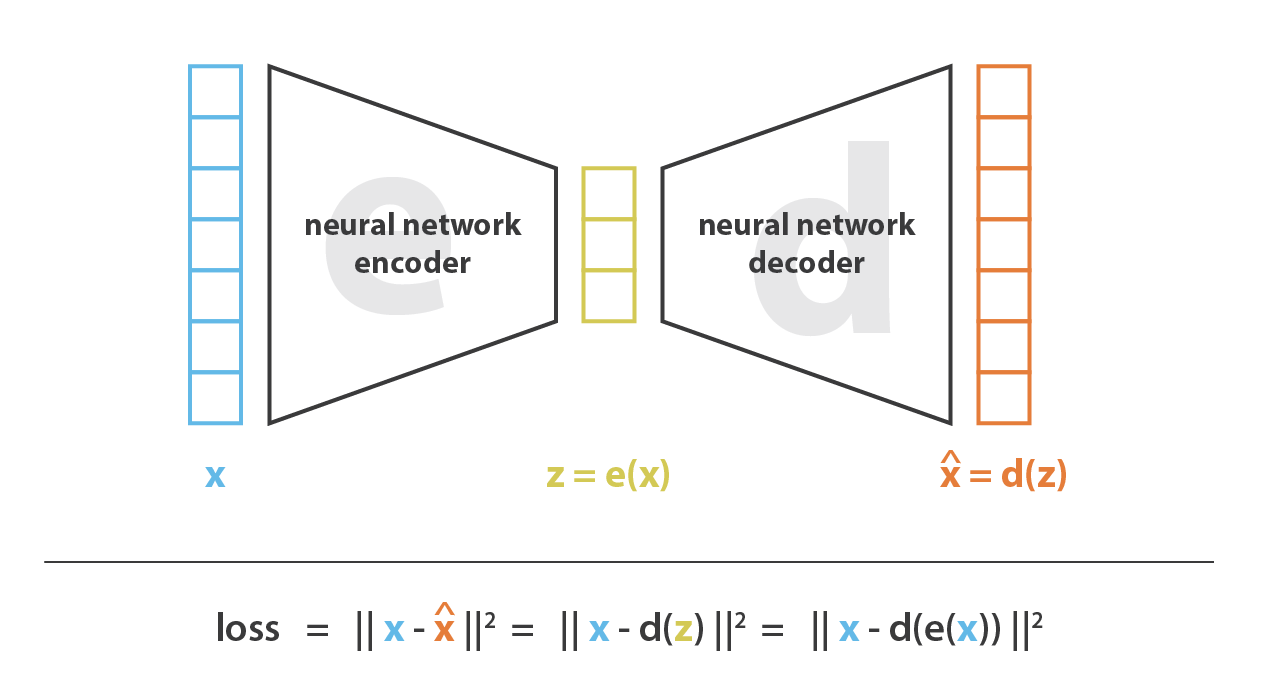
<sup>Image retrieved from https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73<sup>

Basic autoencoders are composed of 2 main components:

1. The **encoder** reduces X inputs to a lower number of features z by feeding the initial data through successive layers with fewer and fewer nodes, until we reach the smallest layer, the **bottleneck**.


2. The **decoder** takes this reduced feature space z and attempts to produce a reconstruction of the inputs X_hat via the reverse process of the encoder.

* It is common practice to make the encoder and the decoder architectures
symmetric, so any additional layer added to one side of the autoencoder should be mirrored on the other.

* The loss function for the basic autoencoder is simply the reconstruction error between the inputs and the reconstructed output. MSE is commonly used for continuous variables, while binary cross-entropy is used for categorical variables.

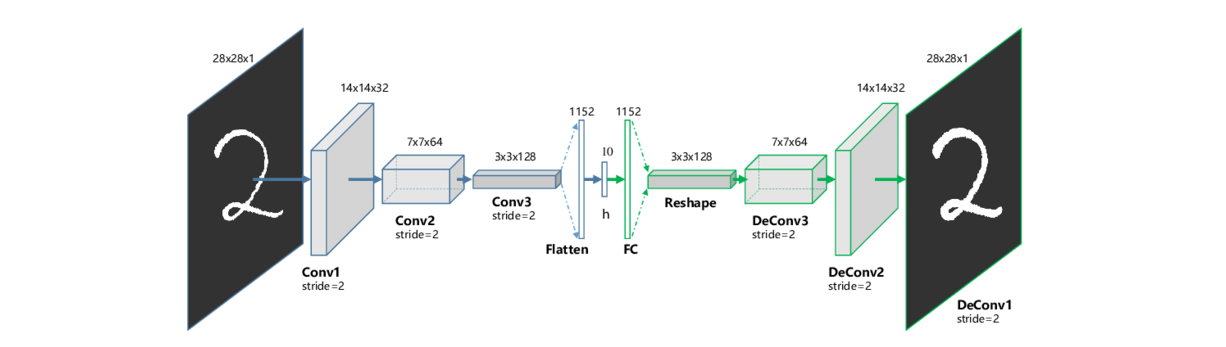
<sup>Guo, X., Liu, X., Zhu, E., & Yin, J. (2017). Deep Clustering with Convolutional Autoencoders. 373–382. https://doi.org/10.1007/978-3-319-70096-0_39<sup>

It should be noted that autoencoders are not strictly confined to being feedforward networks. Above is an example of a convolutional autoencoder<sup>2</sup> which first passes the image through 3 different convolutional layers before flattening the resulting pixels and passing it through the bottleneck.

This flexibility allows autoencoders to be used for a wide variety of tasks including image denoising<sup>2,3</sup>, watermark removal<sup>4</sup>, and dimension reduction into clustering<sup>5</sup>

## Autoencoders vs PCA

You might say wait, I already know a tried and true method for dimension reduction which seems much simpler than all this encoder decoder nonsense - Principle Component Analysis!

PCA is related to Autoencoders in much the same way multiple linear regression is related to feedforward neural networks. With a single layer and a linear activation they are identical methods, but in practice the neural networks often have more complexity that lead to notable differences:



*   PCA is always a linear projection, while autoencoders are able to model complex nonlinear functions by varying hidden layers and activation functions

*   The strategy for PCA dimension reduction is straightforward (reduce maximum variance w/ orthogonal steps), while autoencoder methodology for reducing dimensions is much more black box due to their neural network nature

*   PCA components are orthogonal (linearly uncorrelated) while autoencoder features may be related as long as they minimize reconstruction error   

Autoencoders are not strictly superior to PCA as they are much more computationally expensive, require training, and are prone to overfitting.  




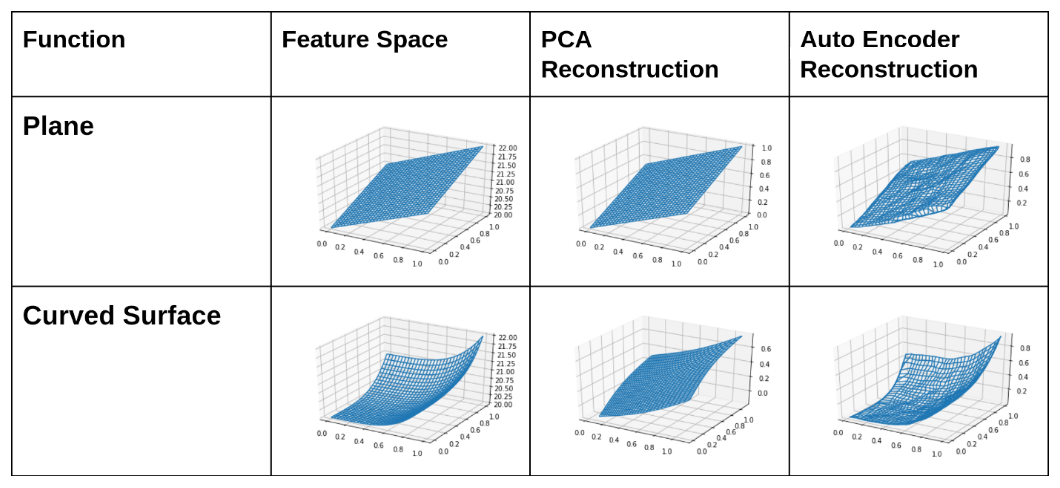
<sup>Image retrieved from https://towardsdatascience.com/autoencoders-vs-pca-when-to-use-which-73de063f5d7 <sup>

Here we can see that PCA does very well in reconstruction of the 3D plane, which has clear linear structure along 2 orthogonal dimensions. PCA would be much less computationally expensive and give an equal or better result than an autoencoder given data of this form for reconstruction.

On the other hand, given a 3D curve, which is non-linear, the autoencoder reconstruction is clearly more accurate to the original.


##Autoencoder vs. PCA Demo
To elaborate on the concepts presented above, we now apply both PCA and autoencoders to the MNIST digit recognition dataset and compare their results.



In [ ]:
#Load Packages
install.packages("keras")
install.packages("parsnip")
install.packages("tidymodels")
library(tidymodels)
library(parsnip)
library(tidyverse)
library(keras)
library(ggplot2)

The MNIST dataset consists of images of handwritten digits represented by 28x28 arrays, with pixel values ranging from 0 to 255. It is conveniently separated into training (60000 observations) and test (10000 observations) sets. We first normalize our X dataset, so that values stay between [0, 1]. While autoencoders can take higher dimensional inputs, clustering algorithms take in 1-D arrays, so we reshape the data from a 60000x28x28 size configuration to 60000x784.

In [ ]:
#Obtain Dataset from Keras
mnist_df <- dataset_mnist()
train_x <- mnist_df$train$x
train_y <- mnist_df$train$y
test_x <- mnist_df$test$x
test_y <- mnist_df$test$y

#Normalize X
train_x <- (train_x/255)
test_x <- (test_x/255)

#Change Shape to 2D
train_x <- array_reshape(train_x, c(nrow(train_x), 28*28))
test_x <- array_reshape(test_x, c(nrow(test_x), 28*28))
print(dim(train_x))

[1] 60000   784


##PCA
We conduct a basic principal component analysis of the MNIST data, first looking at the plot of cumulative proportion of variance explained.

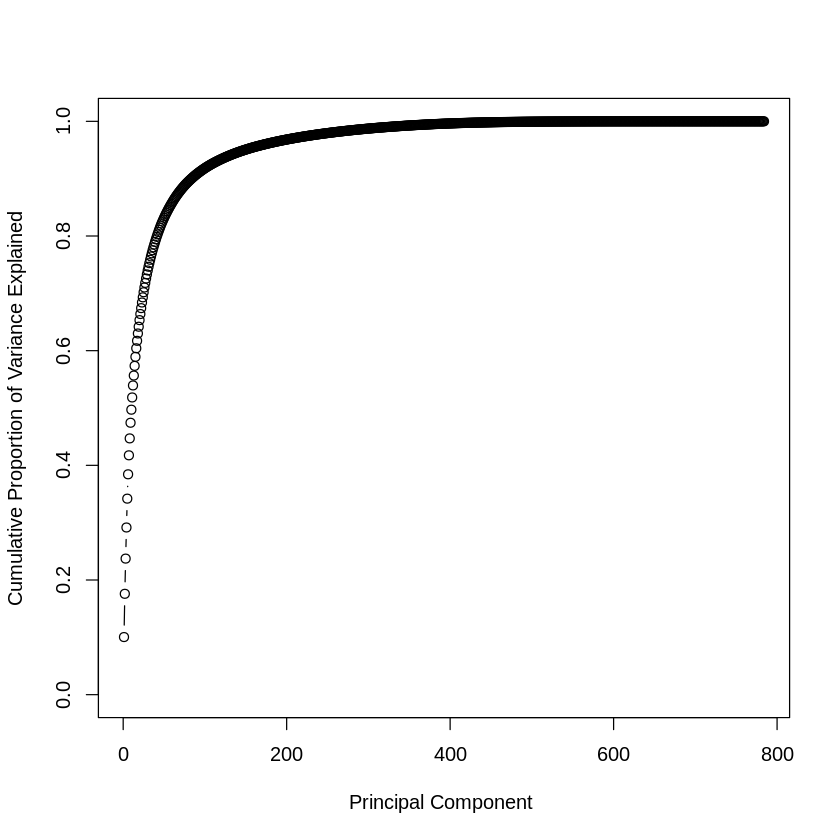

In [ ]:
pca_result <- prcomp(test_x, retx = TRUE)
pca_variance <- pca_result$sdev^2
percent_variance <- cumsum(pca_variance)/sum(pca_variance)
plot(percent_variance, xlab="Principal Component ",
     ylab = " Cumulative Proportion of Variance Explained ",
     ylim=c(0,1), type = "b")

We see that the first 84 principal components account for 90% of the variation, which seems high. In the autoencoder steps later on, we see if we can capture the essence of the digit images using just 10 features.

In [ ]:
min(which(percent_variance >= 0.9))
percent_variance[84]

[1] 84

[1] 0.9007162

Next, we plot the first two principal components and label the points using our y variable. We do not see much clustering, indicating that PCA did not do a great job of separating out the digit images from one another.

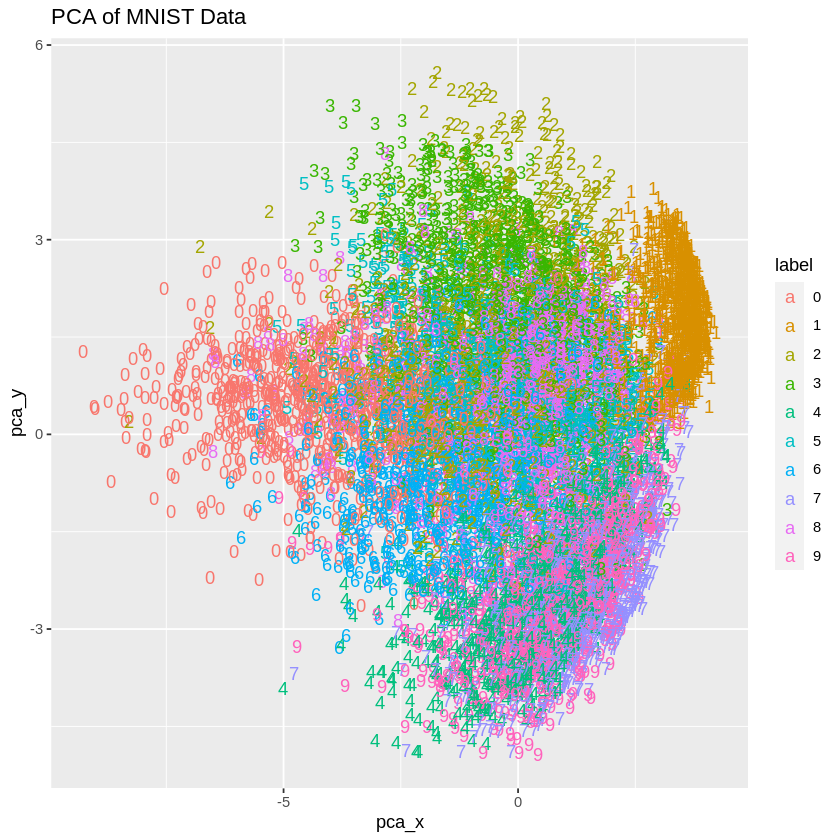

In [ ]:
#Project the first two principal components on the test set
pca_plot_df <- data.frame(pca_x = pca_result$x[, 1], pca_y = pca_result$x[, 2], label = as.factor(test_y))
ggplot(pca_plot_df, aes(x = pca_x, y = pca_y, color = label)) +
  ggtitle("PCA of MNIST Data") +
  geom_text(aes(label = label))

Next, we want to evaluate our reconstruction loss and eventually compare it with that of the autoencoder and variational autoencoder methods. We multiply X by the transpose of the rotation matrix to reconstruct the original data matrix, using k number of principal components. In order to find the MSE, we subtract the training data from the reconstructed data and square it. We do this for every value of k from 1 to 10 and plot the resulting MSE.

In [ ]:
# PCA reconstruction
pca.recon <- function(pca, x, k){
  mu <- matrix(rep(pca_result$center, nrow(pca_result$x)), nrow = nrow(pca_result$x), byrow = T)
  recon <- pca_result$x[,1:k] %*% t(pca_result$rotation[,1:k]) + mu
  mse <- mean((recon - x)^2)
  return(list(x = recon, mse = mse))
}
xhat <- rep(NA, 10)
for(k in 1:10){
  xhat[k] <- pca.recon(pca, test_x, k)$mse
}


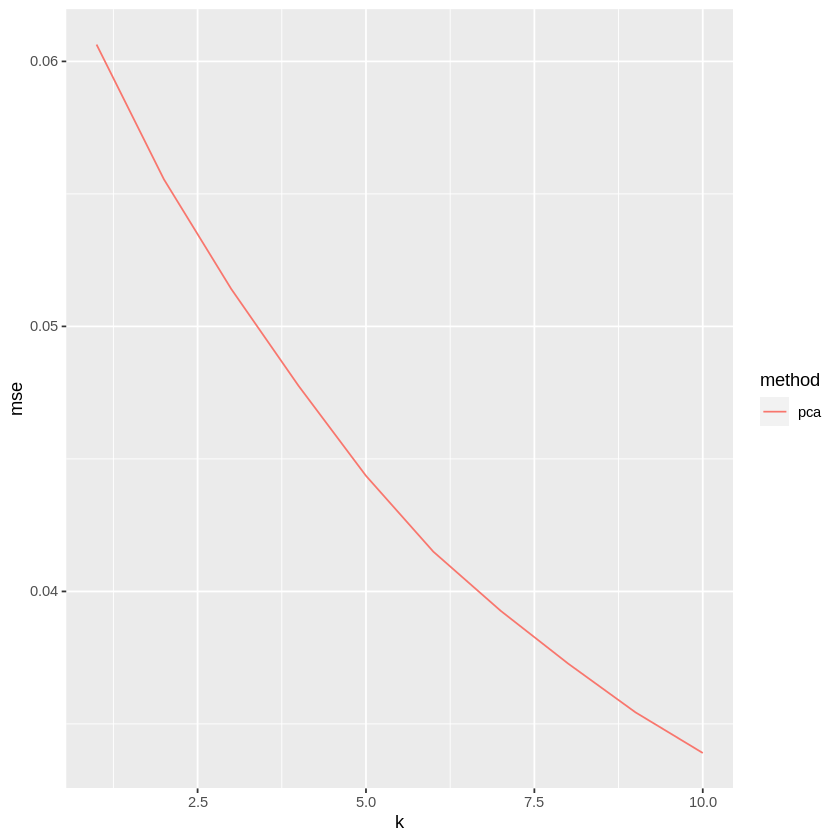

In [ ]:
df <- data.frame(k = c(1:10), mse = c(xhat), method = c(rep("pca", 10)))
ggplot(df, aes(x = k, y = mse, col = method)) + geom_line()

In [ ]:
#MSE at k=10
xhat[10]

[1] 0.03390264

We see that as k increases, MSE decreases, reaching MSE=0.034 at k=10. Now, we use our autoencoder algorithm to reduce the dimensions of our dataset and compare the results.

##Autoencoder for MNIST

Our input size is the number of features in our dataset, 784, while the size of our latent space corresponds to the number of desired features. In this case, it is 10, the number of numeric digits.

First, we create an input layer for our encoder. Then, we build the encoder architecture using our understanding of neural networks. We choose the ReLU activation function for our second layer, with half the number of nodes as in our input layer. For our third layer, the bottleneck, we shrink the number of nodes to the size of our desired reduced feature space. The data should now be a 60000x10 matrix.

From here, we define our decoder layers. We take the input from the latent space and add on a second layer, with the unit size equal to half the number of nodes as the initial input layer. To maintain symmetry with the encoder component, we also use the ReLU activation function. Finally, we add on the last layer, which outputs the same number of nodes as our initial input layer. We use the sigmoid activation function in order to coerce output values between [0,1], to match our input settings and allow for visualization.

We nest the models within each other to build the autoencoder.

In [ ]:
#Define Input Size
input_size <- ncol(train_x)
latent_size <- 10

In [ ]:
#Autoencoder Architecture
image_encoder <- keras_model_sequential()
image_encoder %>%
  layer_dense(units=input_size/2, activation="relu", input_shape=ncol(train_x)) %>%
  layer_dense(units=10, activation="relu", name="bottleneck") %>%
  layer_dense(units=input_size/2, activation="relu") %>%
  layer_dense(units=input_size, activation="sigmoid")

#Define Loss Function and Optimizer
image_encoder %>% compile(
  loss = "mean_squared_error",
  optimizer = "adam"
)

#Train Model
image_history <- image_encoder %>% fit(
  x = train_x,
  y = train_x,
  epochs = 50,
  batch_size = 128,
  validation_split = 0.8,
  callbacks = callback_early_stopping(patience = 5)
)

We train the data using the adam optimizer and define our loss function as MSE. Then, we plot the loss against the number of epochs for both our validation and training data. We see that the validation curve is above the training curve, indicative of some overfitting. Our MSE of 0.02 is lower than the MSE derived from PCA.

`geom_smooth()` using formula 'y ~ x'



loss 
0.02029522

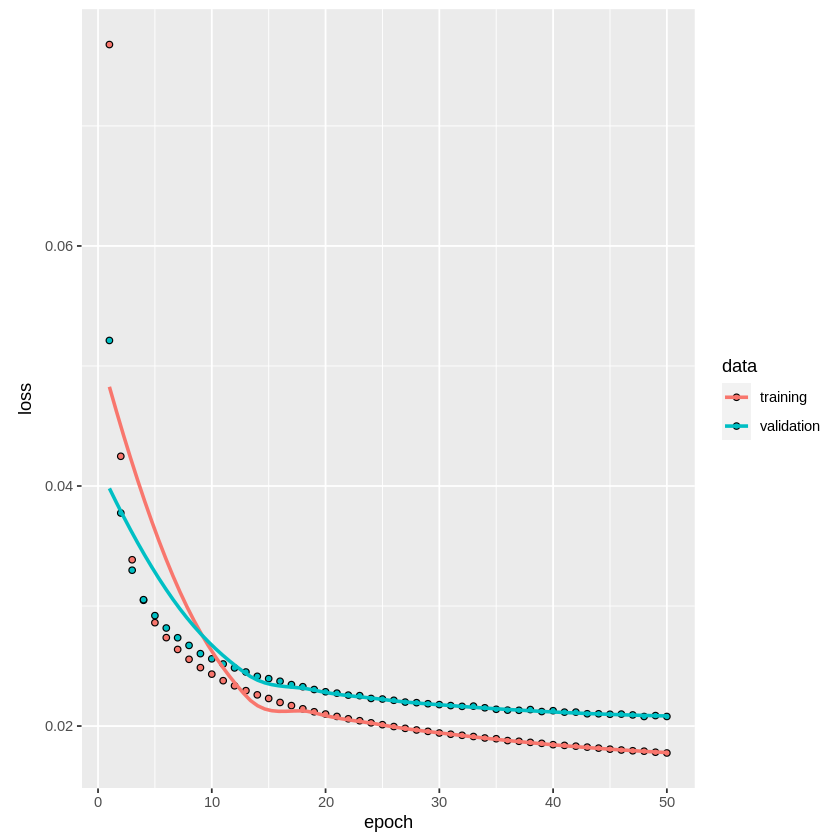

In [ ]:
plot(image_history)
image_encoder %>% evaluate(test_x, test_x, verbose = 0)

Next, we extract the bottleneck layer and use that to compress the training data, ending up with 10 features.

In [ ]:
# extract the bottleneck layer
intermediate_layer_model <- keras_model(inputs = image_encoder$input, outputs = get_layer(image_encoder, "bottleneck")$output)
intermediate_output <- predict(intermediate_layer_model, train_x)

For PCA, the principal components are innately orthogonal and ordered from explaining the most to the least variance, but for autoencoders, they can be related and are non-ordinal. Thus, we can plot from any 2 latent space dimensions. We choose the first and third latent space features.

Our plot does not show much innate clustering among the two dimensions, but due to the black box nature of the NN and the innate relatedness and non-ordinal nature of the latent space, this plot is not as informative as one would hope.

In [ ]:
aen_output_df <- data.frame(node1 = intermediate_output[,1], node2 = intermediate_output[,3], label = as.factor(train_y))
ae_plot <- ggplot(aen_output_df, aes(x = node1, y = node2, color = label)) +
  ggtitle("Autoencoder of MNIST Data") +
  geom_text(aes(label = label)) +
  theme(legend.position = "none")

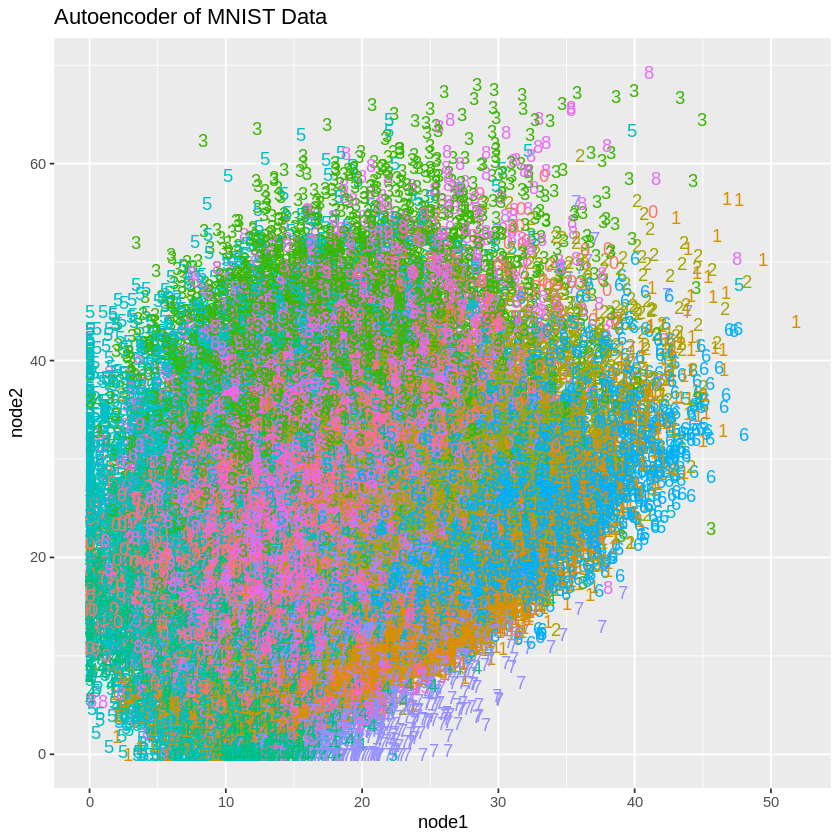

In [ ]:
ae_plot

Finally, to check that we have successfully fit the neural network, from encoder to decoder, we attempt to use the trained autoencoder to reconstruct on the test dataset.

In [ ]:
autoencoder_model <- keras_model(inputs=image_encoder$input, outputs=image_encoder$output)
autoencode_image <- predict(autoencoder_model, test_x)


We fit ten images each from the test data and the predicted data, side-by-side. The predicted images on the left represent the reconstructed images with a relatively high degree of clarity for most digits, with the exception of the antepenulatimate and penultimate images.

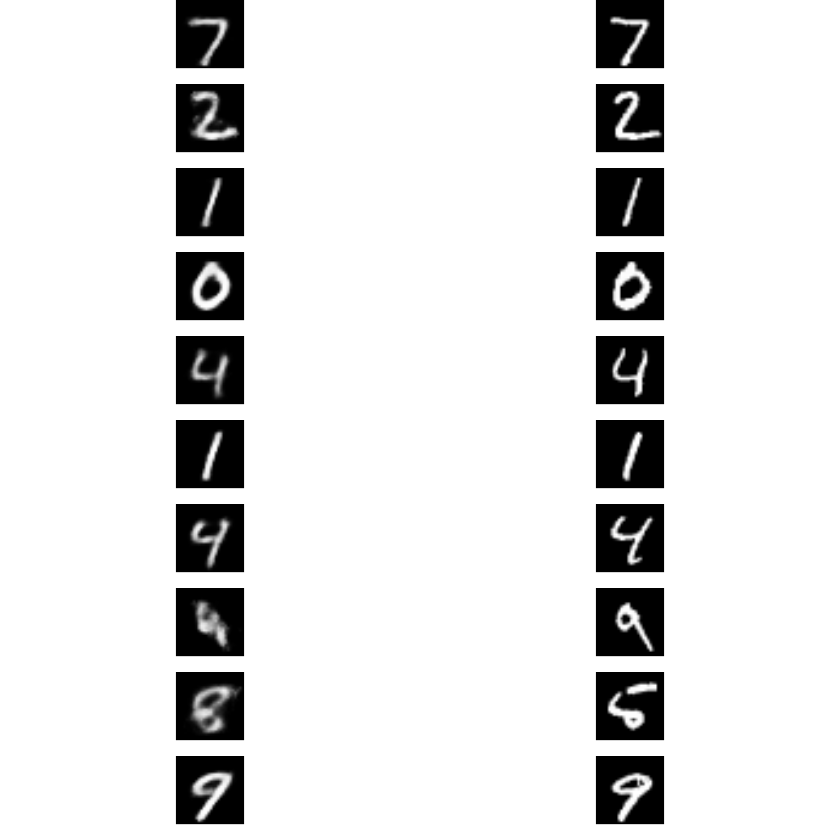

In [ ]:
testdata <- test_x[0:10, ]

#Reshape output from 10000x784 to 10000x28x28 for visualization
pred_images = array_reshape(autoencode_image, dim=c(dim(autoencode_image)[1], 28, 28))
orig_images = array_reshape(testdata, dim=c(dim(testdata)[1], 28, 28))

op = par(mfrow=c(n,2), mar=c(1,0,0,0))

for (i in 1:10)
{
  plot(as.raster(pred_images[i,,]))
  plot(as.raster(orig_images[i,,]))
}

In order to compare the autoencoder approach vs. PCA, we construct 6 different autoencoder models with varying latent space sizes and plot their corresponding MSEs.

In [ ]:
aen_mse <- rep(NA, 5)
for(k in 5:10){
  image_encoder <- keras_model_sequential()
  image_encoder %>%
    layer_dense(units=ncol(train_x)/2, activation="relu", input_shape=ncol(train_x)) %>%
    #layer_activation_leaky_relu() %>%
    layer_dense(units=10, activation="relu", name="bottleneck") %>%
    #layer_activation_leaky_relu() %>%
    layer_dense(units=ncol(train_x)/2, activation="relu") %>%
    #layer_activation_leaky_relu() %>%
    layer_dense(units=ncol(train_x), activation="sigmoid")
    #layer_activation_leaky_relu() %>%

  image_encoder %>% compile(
    loss = "mean_squared_error",
    optimizer = "adam"
  )

  image_encoder %>% fit(
    x = train_x,
    y = train_x,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.8,
    callbacks = callback_early_stopping(patience = 5)
  )

  aen_mse[k] <- unname(evaluate(image_encoder, train_x, train_x))
}


Our results show that the autoencoder method had substantially lower MSE from k=5 to k=10. We excluded the results for autoencoders from k=1 to k=4 due to computation time.

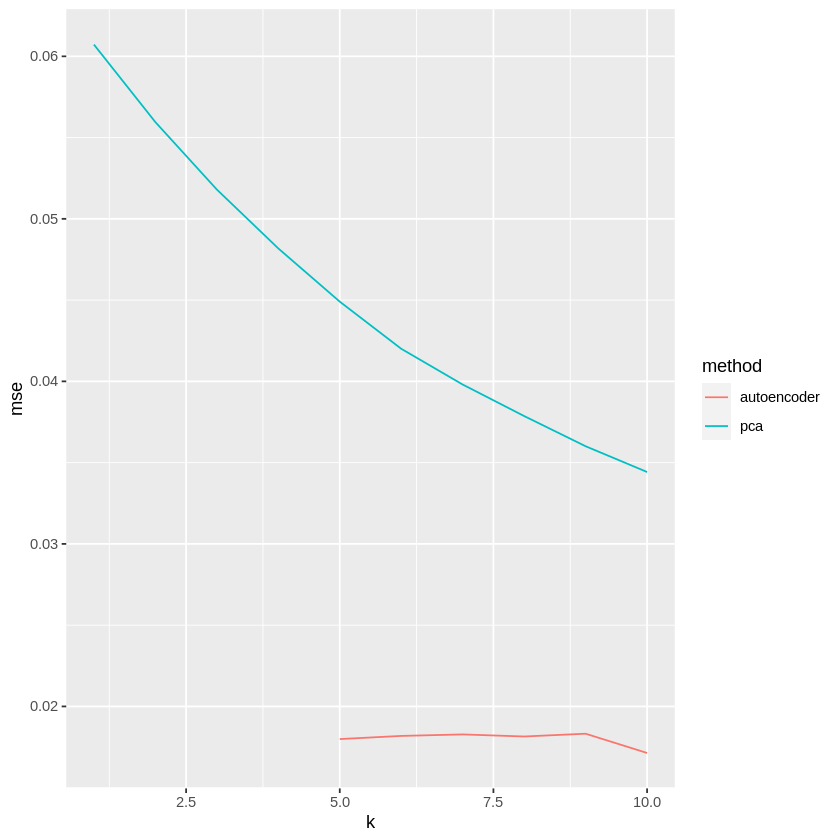

In [ ]:
df <- data.frame(k = c(5:10, 5:10), mse = c(xhat, aen_mse[5:10]), method = c(rep("pca", 6), rep("autoencoder", 6)))
ggplot(df, aes(x = k, y = mse, col = method)) + geom_line()

In summary, our autoencoder appears to work better than PCA for reducing the dimensions of the image files, generating lower MSEs. We now present a commonly used version of the autoencoder method, discuss its merits, and apply it to the MNIST dataset.

## Variational Autoencoders

In order to understand variational autoencoders, we must first gain a better understanding of the latent space, and the shortcomings of traditional autoencoders with respect to that space.

The latent space represents the z dimensional space that our bottleneck representation of the data exists in. Data is encoded from the original set of P features into this space, and each point in the space has a unique encoding (represented by a latent space vector). Similar data will of course generate similar encodings, for example in the MNIST data we would expect inputs of the same digit type to encode into similar latent space vectors. If we visualize the latent space as a 2D area, these clusters of encoded data would form “pools” where we could easily take a point from a pool to decode into an example of the digit.  


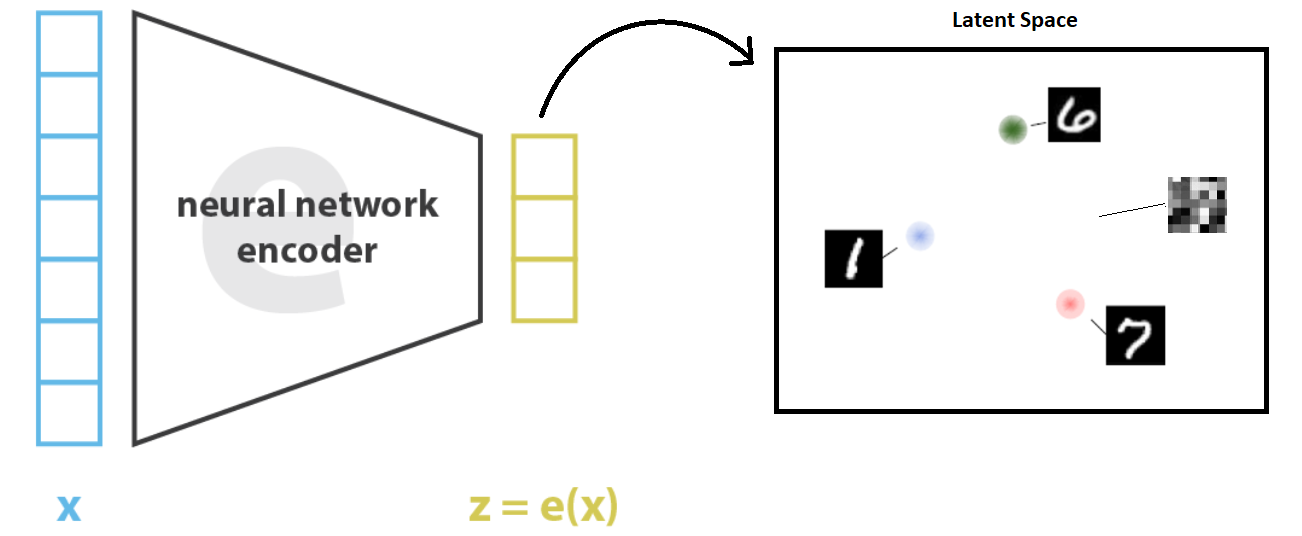
<sup>Image retrieved from https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73<sup>

Remember that the traditional autoencoder loss function optimized solely to **minimize the reconstruction error on the training data**, with little regard to how the latent space ends up structured as long as it “gets the job done”. As a result, the network is incentivized to overfit with respect to the latent space and the default autoencoder has issues with **continuity** and **completeness**.


*   Continuity - two close pools will not decode into similar “ideas” due to the irregularity of the latent space, for example the digits 1 and 7 look very similar but would not necessarily be close in the latent space.

*   Completeness - any point encoded outside of a learned area/pool is decoded into “meaningless” outputs or gibberish, which is an overfitting issue when the test set brings in new digits that may fall outside these trained areas.





How do we solve these issues? Enter variational autoencoders<sup>6</sup>:

  



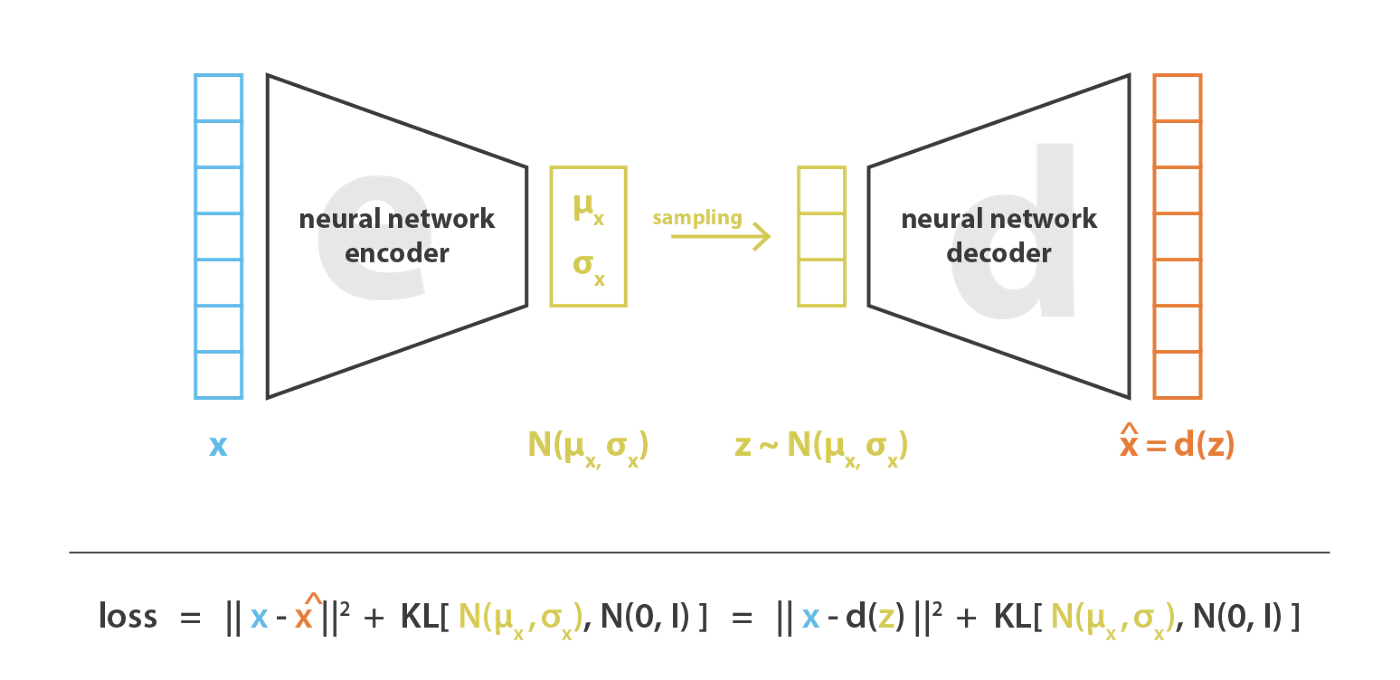
<sup>Image retrieved from https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73<sup>

Variational autoencoders solve this problem by encoding each input as a regularized distribution in the latent space rather than a point, and sampling from this distribution to generate decoded outputs for reconstruction error. In order to accomplish this, a new structure (encoding the distribution/ sampling) and loss function (encoding the regularization) are used.

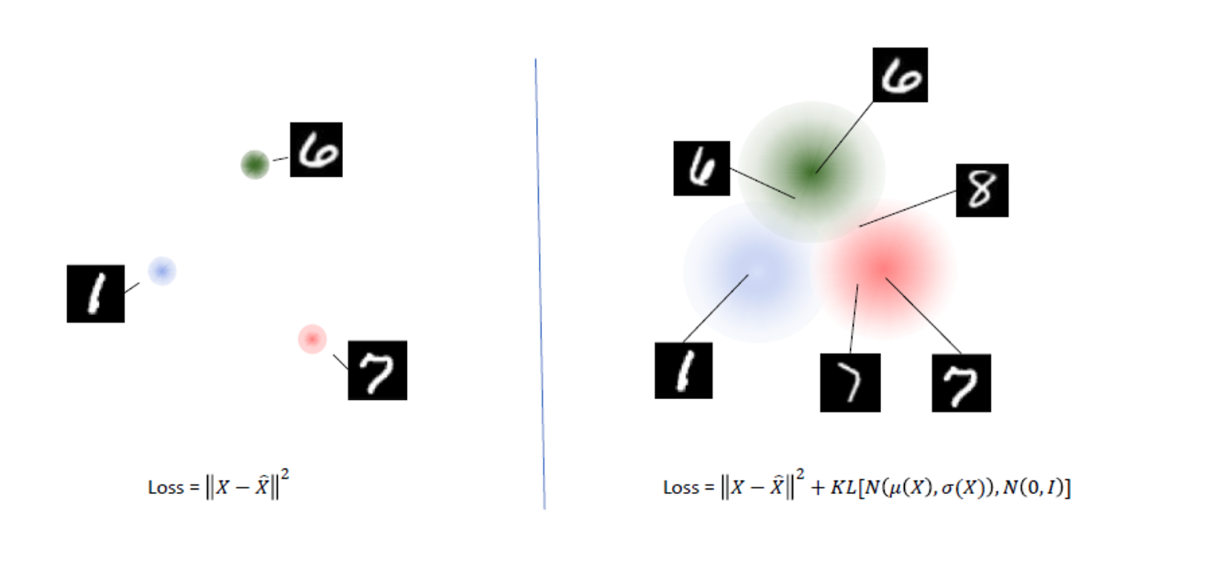
<sup>Image retrieved from course slides<sup>

With this regularization term, we prevent the model from encoding data far apart in the latent space and encourage returned distributions to “overlap”as much as possible, satisfying this way the expected continuity and completeness conditions. Additionally, single points are now spread into gradients due to the abstraction to a distribution. Now, points between two “ideas” in the latent space will both be meaningful and ideologically a mix of the areas they are between.

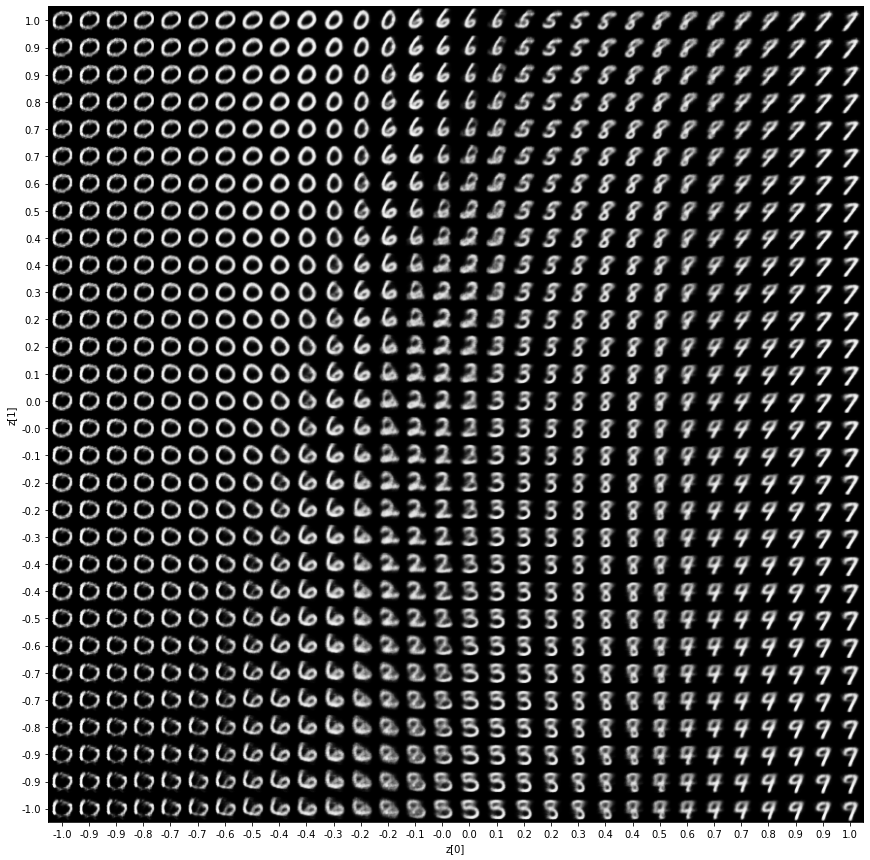


<sup>Image retrieved from https://www.tensorflow.org/tutorials/generative/cvae<sup>

The benefits of variational autoencoders are clear from an overfitting standpoint, but where they shine is allowing generation of novel data once trained. Since the latent space is continuous, we can use it to “fill in the blanks” between the input data. Sampling random latent space vectors and running them through the decoder allows us to generate prototype data that did not exist before. For example, using MNIST data, we can sample a wide range and get as outputs new digits that look like handwritten halfway points between existing digits. Another practical application is to infer unseen cell states from the regularized latent space generated from encoding existing cell states<sup>7,8</sup>.

**Variational Autoencoder Applied to MNIST**

To implement the variational autoencoder, we reuse much of the configurations of the autoencoder architecture. Instead of the MSE, we create a loss function from the sum of the MSE and the Kullback-Leibler Divergence. We encode each of the inputs from our second layer as regularized distributions with the prior belief that each input is normally distributed. If we didn't assume a prior distribution, it would make the distributions tight, as if they were points, to try to minimize the reconstruction error. We borrow much of this code from Daniel Oehm.


In [ ]:
#Include before implementing VAE to avoid tensorflow error message
tensorflow::tf$compat$v1$disable_eager_execution()

#Define input and latent size
input_size <- ncol(train_x)
latent_size <- 10

#Encoder
encoder_input_vae <- layer_input(shape=c(input_size))
layer_one <- layer_dense(encoder_input_vae, units=input_size/2, activation = "relu")

#Latent Space, use mean and std/variance layers to define a distribution
z_mean <- layer_dense(layer_one, latent_size)
z_log_var <- layer_dense(layer_one, latent_size)

#Create encoder
encoder <- keras_model(encoder_input_vae, z_mean)
summary(encoder)

#Sample from latent space distribution for latent space vector that we will pass to decoder
sampling <- function(arg){
  z_mean <- arg[, 1:(latent_size)]
  z_log_var <- arg[, (latent_size + 1):(2 * latent_size)]
  epsilon <- k_random_normal(shape = c(k_shape(z_mean)[[1]]), mean=0)
  z_mean + k_exp(z_log_var/2)*epsilon
}

z <- layer_concatenate(list(z_mean, z_log_var)) %>%
  layer_lambda(sampling)

#Decoder
decoder_layer <- layer_dense(units = input_size/2, activation = "relu")
decoder_mean <- layer_dense(units = input_size, activation = "sigmoid")
h_decoded <- decoder_layer(z)
x_decoded_mean <- decoder_mean(h_decoded)

vae <- keras_model(encoder_input_vae, x_decoded_mean)
summary(vae)

#Define Loss Function, including new KL divergence term which regularizes latent space
vae_loss <- function(input, x_decoded_mean){
  xent_loss=(input_size/1.0)*loss_mean_squared_error(input, x_decoded_mean)
  kl_loss=-0.5*k_mean(1+z_log_var-k_square(z_mean)-k_exp(z_log_var), axis=-1)
  xent_loss + kl_loss
}

#Compile with new loss function
vae %>% compile(optimizer = "adam", loss = vae_loss)

#Fit Model
vae_history <- vae %>% fit(
  train_x, train_x,
  shuffle = TRUE,
  epochs = 20,
  batch_size = 64,
  validation_data = list(test_x, test_x)
)

# optional: fit generative model to get "novel" outputs from latent space points
decoder_input <- layer_input(shape = latent_size)
h_decoded_2 <- decoder_layer(decoder_input_vae)
x_decoded_mean_2 <- decoder_mean(h_decoded_2)
generator <- keras_model(decoder_input_vae, x_decoded_mean_2)
summary(generator)


Model: "model_16"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_1 (InputLayer)               [(None, 784)]                   0           
                                                                                
 dense_55 (Dense)                   (None, 256)                     200960      
                                                                                
 dense_56 (Dense)                   (None, 10)                      2570        
                                                                                
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
________________________________________________________________________________
Model: "model_17"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 

As before, we assess the plot of the loss function against the number of epochs. We see that the training and validation curves converge around the 15th epoch. Since the loss functions for our two encoders are different, we cannot compare them with each other. Our final loss value is 15.123.

`geom_smooth()` using formula 'y ~ x'



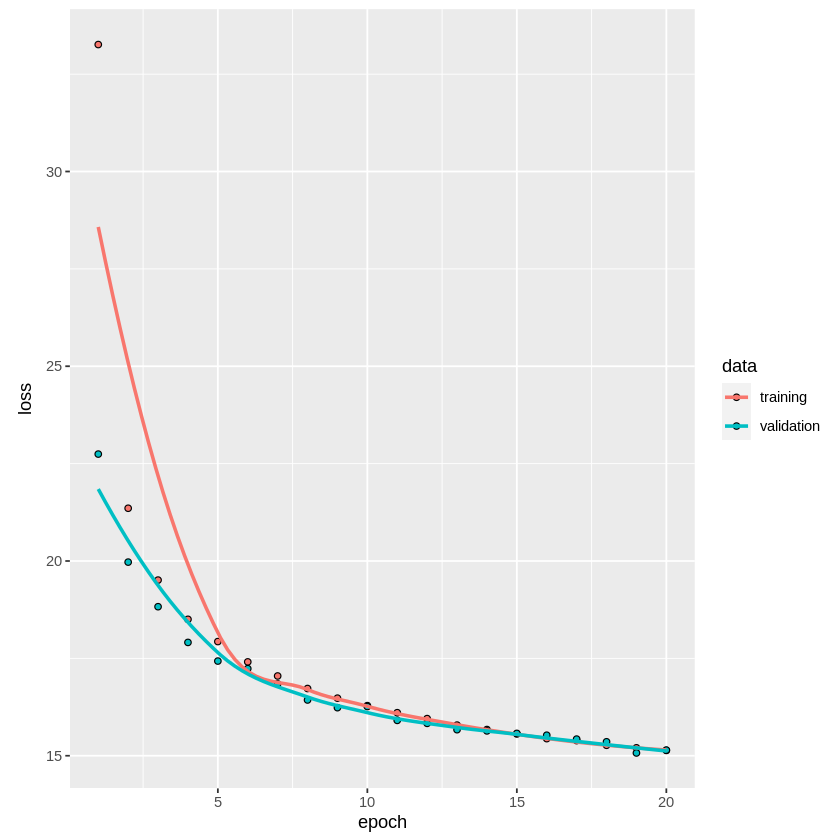

In [ ]:
plot(vae_history)

In [ ]:
vae %>% evaluate(test_x, test_x, verbose = 0)

loss 
15.12349

Finally, to test the variational autoencoder, we attempt to reconstruct on the test dataset. We fit ten images each from the test data and the predicted data, side-by-side. The images resemble each other, but the predicted images on the right suffers from some blurring.

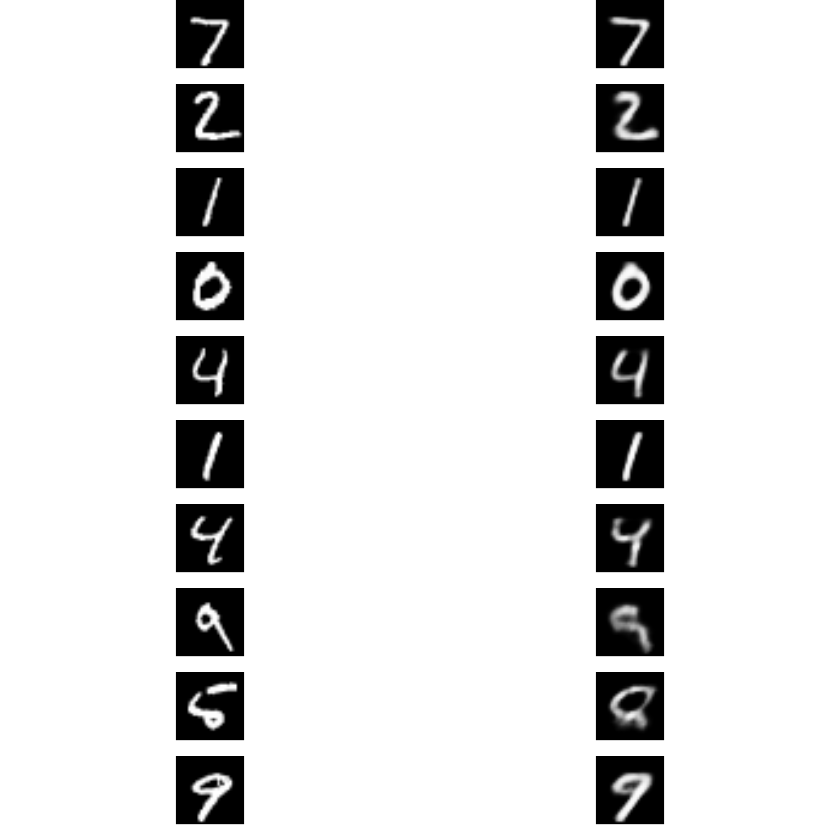

In [ ]:
n = 10
test =  test_x[0:n,]
x_test_encoded <- predict(encoder, test)

decoded_imgs = generator %>% predict(x_test_encoded)
pred_images = array_reshape(decoded_imgs, dim=c(dim(decoded_imgs)[1], 28, 28))
orig_images = array_reshape(test, dim=c(dim(test)[1], 28, 28))

op = par(mfrow=c(n,2), mar=c(1,0,0,0))
for (i in 1:n)
{
  plot(as.raster(orig_images[i,,]))
  plot(as.raster(pred_images[i,,]))
}

While we cannot compare the plots of the loss functions, we can see that the variational autoencoder's reconstruction of the MNIST dataset performs similarly to the autoencoder's. Overall, we have found reasonable low-dimensional representations of MNIST digits using a method that can capture non-linearity.


Thank you for reading. We hope this demo can serve as a starting guide for your neural network learning journey!

References:

1.   Reducing the Dimensionality of Data with Neural Networks. (n.d.). Retrieved May 13, 2022, from https://www.science.org/doi/10.1126/science.1127647

2.   Guo, X., Liu, X., Zhu, E., & Yin, J. (2017). Deep Clustering with Convolutional Autoencoders. 373–382. https://doi.org/10.1007/978-3-319-70096-0_39
3.   Gondara, L. (2016). Medical Image Denoising Using Convolutional Denoising Autoencoders. 241–246. https://doi.org/10.1109/ICDMW.2016.0041
4.   Haribabu, K., Subrahmanyam, G. R. K. S., & Mishra, D. (2015). A robust digital image watermarking technique using auto encoder based convolutional neural networks. 2015 IEEE Workshop on Computational Intelligence: Theories, Applications and Future Directions (WCI), 1–6. https://doi.org/10.1109/WCI.2015.7495522
5.   Geddes, T. A., Kim, T., Nan, L., Burchfield, J. G., Yang, J. Y. H., Tao, D., & Yang, P. (2019). Autoencoder-based cluster ensembles for single-cell RNA-seq data analysis. BMC Bioinformatics, 20(19), 660. https://doi.org/10.1186/s12859-019-3179-5

6.   Kingma, D., & Welling, M. (2019). An Introduction to Variational Autoencoders. https://doi.org/10.1561/9781680836233

7.   Heydari, A. A. (2021). ACTIVA: Realistic single-cellRNA-seq generation with automatic cell-type identificationusing introspective variational autoencoders. Zenodo. https://doi.org/10.5281/zenodo.5842658

8.   How to Build Simple Autoencoder with Keras in R. (2020). DataTechNotes. https://www.datatechnotes.com/2020/02/how-to-build-simple-autoencoder-with-keras-in-r.html?m=1

9.   Lotfollahi, M., Wolf, F. A., & Theis, F. J. (2019). ScGen predicts single-cell perturbation responses. Nature Methods, 16(8), 715–721. https://doi.org/10.1038/s41592-019-0494-8

10.   Oehm, D. (2018). PCA vs Autoencoders for Dimensionality Reduction. R-bloggers. https://www.r-bloggers.com/2018/07/pca-vs-autoencoders-for-dimensionality-reduction/




